We'll first define the inputs to the model. These will be read into the notebook from csv files.

In [2]:
# Load packages
import numpy as np
import pandas as pd

In [3]:
# Load in the trips csv file
# NOTE: As written, this will search back one directory level from the current file and in a "Data" folder containing the datasets. The reference will be different unless you define the same directory structure.
trip_df = pd.read_csv("../Data/trips_all.csv")
# We want to be able to filter by home location (not given in trip data) so need hh_all.csv
hh_df = pd.read_csv("../Data/hh_all.csv")
trip_df = trip_df.merge(hh_df.loc[:,["UID","hh_cbsa"]], on="UID")
# Filter for your given CBSA
my_trips = trip_df.loc[(trip_df.hh_cbsa=="40900")]

C:\Users\jhawkins17\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (26,28,67,91,122,124,137,138,153,154) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\jhawkins17\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (58) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# Origin trip total is the county of trips in the trip table by origin zipcode where zipcode > 0
# I.e., it's a real zipcode
o_trips = my_trips.loc[my_trips.o_zip>0].groupby("o_zip").count()["sampno"]
# Destination trip total is the county of trips in the trip table by destination zipcode where zipcode > 0
# I.e., it's a real zipcode
d_trips = my_trips.loc[my_trips.d_zip>0].groupby("d_zip").count()["sampno"]
# Origin and destination zipcodes may not be consistent, so we need to perform some adjustments to them.
od_check = o_trips.ne(d_trips)
od_check.update(o_trips)
o_trips = od_check
# Set the origin total equal to zero where it appears in the destination list but  not origin list
o_trips[o_trips==True] = 0
od_check = d_trips.ne(o_trips)
od_check.update(d_trips)
d_trips = od_check
# Set the destination total equal to zero where it appears in the origin list but  not destination list
d_trips[d_trips==True] = 0

# Make sure origin total = destination total
filt_o_trips = o_trips.loc[(o_trips>0) * (d_trips>0)]
filt_d_trips = d_trips.loc[(o_trips>0) * (d_trips>0)]

if (filt_o_trips.sum()<filt_d_trips.sum()):
    filt_o_trips = filt_o_trips * filt_d_trips.sum()/filt_o_trips.sum()
else:
    filt_d_trips = filt_d_trips * filt_o_trips.sum()/filt_d_trips.sum()
    
# Print some diagnostics to check everything is working nicely
# The total origin rows should equal the total destination rows - i.e., 438 for my dataset
print(filt_o_trips.shape[0],filt_d_trips.shape[0])
# The total trips should be equal in the final dataset
print(filt_o_trips.sum(),filt_d_trips.sum())
# The total trips may not be equal in the unadjusted dataset
print(o_trips.sum(),d_trips.sum())

438 438
27282.0 27281.999999999996
27340.0 27329.0


In [6]:
# Create a dataframe with the origin/destination zone pairs as indices and a blank column to fill with travel times 
index = pd.MultiIndex.from_product([filt_o_trips.index,filt_d_trips.index], names=["o_zip","d_zip"])
tt_trips = pd.DataFrame(index=index,columns=["trvlcmin"])

# Get the travel time for trips with auto modes between o_zip and d_zip
fill_tt_trips1 = my_trips.loc[(my_trips.trptrans>2) & (my_trips.trptrans<7)].groupby(["o_zip","d_zip"]).trvlcmin.mean()
my_trips2 = my_trips.rename(columns={"o_zip":"d_zip1", "d_zip":"o_zip1"})
# Increase the coverage of the travel time data by swapping the origin/destination zones and repeating process
fill_tt_trips2 = my_trips2.loc[(my_trips2.trptrans>2) & (my_trips2.trptrans<7)].groupby(["o_zip1","d_zip1"]).trvlcmin.mean()
tt_trips.update(fill_tt_trips1)
tt_trips.update(fill_tt_trips2)
tt_trips = tt_trips.reset_index()
# Some travel times are small or inconsistent. Set them to 5 minutes as an average intrazonal time.
tt_trips.loc[tt_trips.trvlcmin<5,"trvlcmin"] = 5

# Pivot the origin/destination locations (o_zip/d_zip) into row/column indices and fill empty cells with 99 min. travel time.
tij = tt_trips.pivot(index="o_zip",columns="d_zip",values="trvlcmin").fillna(99).values
Oi = filt_o_trips.values
Dj = filt_d_trips.values

# Basic Gravity Model
We will define a function to handle the iterations. The impedance function is given by $f_{ij}=0.45exp(-t_{ij})$.

## Destination-based Gravity Model

In [7]:
"""
This function maintains the origin constrain
It can be iteratively called to update the destination totals to match destination constraints - i.e., perform a gravity update.
Inputs:
Oi = known origin trip totals by zone
Dj = known destination trip totals by zone
tij = known travel time between origin zone i and destination zone j
Returns:
A 2D array of trip totals by i/j zone pair
"""
def dest_gravity(Oi,Dj,tij):
    Dj_new = Dj
    fij = 0.45*np.exp(-1*tij) # The impedance function is given by the inverse of the squared tij travel times
    # Denominator of gravity expression = element-wise sum D_j x f_ij across columns
    denom = (Dj_new*fij).sum(axis=1)
    Tij = np.ones((Oi.shape[0],Dj.shape[0])) # Define an array with correct dimensions to update
    # Trips are given by Oi x Dj_new x fij / denom
    for i in range(Oi.shape[0]):
            Tij[i,:] = Oi[i] * Dj_new * fij[i,:] / denom[i]
    return(Tij)

We will define a loop at continues until all $R_i$ factors are below an $\epsilon$ difference from 1.0 as user-defined (we're use 2%).

Now let's define the full gravity model with an iterative call to dest_gravity().

In [8]:
eps = 0.02 # Check against a 2% difference

eps_vector = np.ones(Oi.shape[0]) # Epsilon vector to be updated as we run the gravity model
Tij = np.ones(tij.shape) # Define a container to store OD trip data that has the correct dimensions

i = 1 # define an iteration counter

while (max(eps_vector)>eps):
    if i==1:
        Dj_new = Dj
    else:
        Dj_new = Dj_new*Rj
        
    Tij = dest_gravity(Oi,Dj_new,tij)
    Rj = Dj/Tij.sum(axis=0)
    eps_vector = np.abs(Rj-1)
    # Print every 50th iteration
    if(i%50==0):
        print("Iteration", i)
        print("Current max. epsilon", max(eps_vector))
    i+=1
print("Final Tij\n", Tij)

Iteration 50
Current max. epsilon 0.5727136928167897
Iteration 100
Current max. epsilon 0.37066072358579394
Iteration 150
Current max. epsilon 0.2503283571398671
Iteration 200
Current max. epsilon 0.1977117976510261
Iteration 250
Current max. epsilon 0.15524422919982483
Iteration 300
Current max. epsilon 0.09600127982311912
Iteration 350
Current max. epsilon 0.09599433833715776
Iteration 400
Current max. epsilon 0.09547568769992432
Iteration 450
Current max. epsilon 0.07172629381496565
Iteration 500
Current max. epsilon 0.06372891659143942
Iteration 550
Current max. epsilon 0.03372903952656614
Iteration 600
Current max. epsilon 0.03196971486460076
Iteration 650
Current max. epsilon 0.031963939502648975
Iteration 700
Current max. epsilon 0.03195585735552631
Iteration 750
Current max. epsilon 0.0319211022597099
Iteration 800
Current max. epsilon 0.0317841244600372
Iteration 850
Current max. epsilon 0.031247635427795073
Iteration 900
Current max. epsilon 0.029340850269442553
Iteration 950

## Origin-based Gravity Model
The same procedure can be used based on adjusting the origin totals and fixing the destination totals.

In [9]:
"""
This function maintains the origin constraint
It can be iteratively called to update the origin totals to match origin constraints - i.e., perform a gravity update.
Inputs:
Oi = known origin trip totals by zone
Dj = known destination trip totals by zone
tij = known travel time between origin zone i and destination zone j
Returns:
A 2D array of trip totals by i/j zone pair
"""
def origin_gravity(Oi,Dj,tij):
    Oi_new = Oi
    fij = 0.45*np.exp(-1*tij) # The impedance function is given by the inverse of the squared tij travel times
    # Denominator of gravity expression = element-wise sum D_j x f_ij across columns
    denom = (Oi_new*fij.transpose()).sum(axis=1) # switch summation dimension from dest_gravity
    # Trips are given by Oi x Dj_new x fij / denom
    for j in range(Oi.shape[0]):
            Tij[:,j] = Oi_new * Dj[j] * fij[:,j] / denom[j]
    return(Tij)

In [10]:
eps = 0.02 # Check against a 2% difference

eps_vector = np.ones(Oi.shape[0]) # Epsilon vector to be updated as we run the gravity model
Tij = np.ones(tij.shape) # Define a container to store OD trip data that has the correct dimensions

i = 1 # define an iteration counter

while (max(eps_vector)>eps):
#while (i<3):
    if i==1:
        Oi_new = Oi
    else:
        Oi_new = Oi_new*Ri

    Tij = origin_gravity(Oi_new,Dj,tij)
    Ri = Oi/Tij.sum(axis=1) # switch summation dimension from dest_gravity
    eps_vector = np.abs(Ri-1)
    # Print every 50th iteration
    if(i%50==0):
        print("Iteration", i)
        print("Current max. epsilon", max(eps_vector))
    i+=1
print("Final Tij\n", Tij)

Iteration 50
Current max. epsilon 0.6587258186726359
Iteration 100
Current max. epsilon 0.3337324271703498
Iteration 150
Current max. epsilon 0.24351429289513282
Iteration 200
Current max. epsilon 0.16715801650365525
Iteration 250
Current max. epsilon 0.15433667542784346
Iteration 300
Current max. epsilon 0.11965124984773756
Iteration 350
Current max. epsilon 0.08759237548406773
Iteration 400
Current max. epsilon 0.08759007247426775
Iteration 450
Current max. epsilon 0.0873019212886903
Iteration 500
Current max. epsilon 0.06384410785682626
Iteration 550
Current max. epsilon 0.02727355619658922
Iteration 600
Current max. epsilon 0.024806598278554914
Iteration 650
Current max. epsilon 0.023301467905050055
Iteration 700
Current max. epsilon 0.022319915108825028
Iteration 750
Current max. epsilon 0.02138656377641135
Final Tij
 [[5.00348458e+00 1.65400221e-36 1.31799777e-20 ... 2.63472366e-20
  4.34223918e-36 6.29998296e-37]
 [1.14479384e-38 4.00278766e+00 1.05439821e-20 ... 2.10777893e-20


## Comparing to Entropy Formulation
We can also use an entropy formulation, which gives the same result as the gravity formulation.

In [11]:
"""
This function maintains the origin constrain
It can be iteratively called to update the destination totals to match destination constraints - i.e., perform an entropy update.
Inputs:
Oi = known origin trip totals by zone
Dj = known destination trip totals by zone
tij = known travel time between origin zone i and destination zone j
Returns:
A 2D array of trip totals by i/j zone pair
"""
def dest_entropy(Oi,Dj,tij):
    Bj = np.ones(Dj.shape[0])
    Ai = 1/Bj
    fij = 0.45*np.exp(-1*tij) # The impedance function is given by the inverse of the squared tij travel times
    # Denominator of gravity expression = element-wise sum D_j x f_ij across columns
    denom = (Dj*Bj*fij).sum(axis=1)
    Tij = np.ones((Oi.shape[0],Dj.shape[0])) # Define an array with correct dimensions to update
    # Trips are given by Oi x Dj_new x fij / denom
    for i in range(Oi.shape[0]):
            Tij[i,:] = Ai*Oi[i] * Dj * fij[i,:] / denom[i]
    return(Tij)

In [12]:
eps = 0.02 # Check against a 2% difference

eps_vector = np.ones(Oi.shape[0]) # Epsilon vector to be updated as we run the gravity model
Tij = np.ones(tij.shape) # Define a container to store OD trip data that has the correct dimensions

i = 1 # define an iteration counter

while (max(eps_vector)>eps):
    if i==1:
        Dj_new = Dj
    else:
        Dj_new = Dj_new*Rj
        
    Tij = dest_entropy(Oi,Dj_new,tij)
    Rj = Dj/Tij.sum(axis=0)
    eps_vector = np.abs(Rj-1)
    # Print every 50th iteration
    if(i%50==0):
        print("Iteration", i)
        print("Current max. epsilon", max(eps_vector))
    i+=1
print("Final Tij\n", Tij)

Iteration 50
Current max. epsilon 0.5727136928167897
Iteration 100
Current max. epsilon 0.37066072358579394
Iteration 150
Current max. epsilon 0.2503283571398671
Iteration 200
Current max. epsilon 0.1977117976510261
Iteration 250
Current max. epsilon 0.15524422919982483
Iteration 300
Current max. epsilon 0.09600127982311912
Iteration 350
Current max. epsilon 0.09599433833715776
Iteration 400
Current max. epsilon 0.09547568769992432
Iteration 450
Current max. epsilon 0.07172629381496565
Iteration 500
Current max. epsilon 0.06372891659143942
Iteration 550
Current max. epsilon 0.03372903952656614
Iteration 600
Current max. epsilon 0.03196971486460076
Iteration 650
Current max. epsilon 0.031963939502648975
Iteration 700
Current max. epsilon 0.03195585735552631
Iteration 750
Current max. epsilon 0.0319211022597099
Iteration 800
Current max. epsilon 0.0317841244600372
Iteration 850
Current max. epsilon 0.031247635427795073
Iteration 900
Current max. epsilon 0.029340850269442553
Iteration 950

# Biproportional Updating
Another common task that can benefit from a "gravity style" approach is biproportional updating to match future O-D trip matrices. Let's define a base year table that we will then update using this approach.

## Gravity-Style Update

In [13]:
# Create a table with dimensions based on origin/destination totals data and random values in [50,150]
Tij_base = np.random.randint(50,150,size=(Oi.shape[0],Dj.shape[0]))

In [14]:
def biprop_gravity(Oi, Dj, Tij_base):
    Dj_new = Dj
    
    # Denominator of gravity expression = element-wise sum D_j x f_ij across columns
    denom = (Dj_new*Tij_base).sum(axis=1)
    Tij = np.ones((Oi.shape[0],Dj.shape[0])) # Define an array with correct dimensions to update
    # Trips are given by Oi x Dj_new x fij / denom
    for i in range(Oi.shape[0]):
            Tij[i,:] = Oi[i] * Dj_new * Tij_base[i,:] / denom[i]
    return(Tij)

In [15]:
eps = 1.001 # Check against a 0.1% difference

Rj = 10*np.ones(Oi.shape[0]) # Rj vector to be updated as we run the gravity model
Tij = Tij_base # Define a container to store OD trip data that has the correct dimensions


i = 1 # define an iteration counter

while (max(Rj)>eps):
    if i==1:
        Dj_new = Dj
    else:
        Dj_new = Dj_new*Rj
        
    Tij = biprop_gravity(Oi,Dj_new,Tij_base)
    Rj = Dj/Tij.sum(axis=0)
    print("Iteration", i)
    print("Current max. Rj", max(Rj))
    i+=1
print("Final Tij\n", Tij)

Iteration 1
Current max. Rj 1.1322701906019075
Iteration 2
Current max. Rj 1.0002934277191997
Final Tij
 [[0.00135347 0.00044981 0.00043295 ... 0.00035263 0.00069361 0.00057088]
 [0.00106212 0.00068481 0.00052189 ... 0.00016732 0.00061427 0.00080653]
 [0.00026136 0.0001693  0.00015688 ... 0.00017023 0.00025851 0.00022487]
 ...
 [0.00035905 0.00038303 0.00023779 ... 0.00013286 0.00016327 0.00026571]
 [0.00093586 0.00084663 0.00023286 ... 0.00026485 0.00045143 0.00041805]
 [0.00092012 0.00085829 0.00023094 ... 0.00020637 0.00065289 0.00039188]]


## Row/Column (Iterative Proportional Updating)
A common and very useful technique for updating a trip matrix is called *iterative proportional updating*, or IPF. In this approach, we iterate between adjusting cell totals to match row totals, then column totals, etc.

In [16]:
def ipf(Tij,Oi,Dj,i):
    if i%2==1: # If it's an add iteration then balance row totals
        R = Oi/Tij.sum(axis=1)
        Tij =  Tij*R[:,np.newaxis] # Need to add dimension so the multiplication occurs across rows not columns
    else: # If it's an odd even iteration then balance column totals
        R = Dj/Tij.sum(axis=0)
        Tij =  Tij*R # Do not add dimension so the multiplication occurs across columns not rows
    
    return (Tij, R)
    

In [17]:
eps = 1.001 # Check against a 0.1% difference

Ri = 10*np.ones(Oi.shape[0]) # Ri vector to be updated as we run the gravity model
Rj = 10*np.ones(Dj.shape[0]) # Rj vector to be updated as we run the gravity model

Tij = Tij_base # Define a container to store OD trip data that has the correct dimensions

i = 1 # define an iteration counter

while ((max(Ri)>eps) or (max(Rj)>eps)):
    if i%2==1: # If it's an odd iteration then balance row totals
        Tij, Ri = ipf(Tij,Oi,Dj,i) 
    else: # If it's an even iteration then balance column totals
        Tij, Rj = ipf(Tij,Oi,Dj,i)

    print("Iteration", i)
    print("Current max. Ri", max(Ri))
    print("Current max. Rj", max(Rj))
    i+=1
print("Final Tij\n", Tij)

Iteration 1
Current max. Ri 0.030308583995784746
Current max. Rj 10.0
Iteration 2
Current max. Ri 0.030308583995784746
Current max. Rj 21.38779540402033
Iteration 3
Current max. Ri 1.133687510092452
Current max. Rj 21.38779540402033
Iteration 4
Current max. Ri 1.133687510092452
Current max. Rj 1.0034865305703693
Iteration 5
Current max. Ri 1.000194171662193
Current max. Rj 1.0034865305703693
Iteration 6
Current max. Ri 1.000194171662193
Current max. Rj 1.0000123700727663
Final Tij
 [[0.001353549332232448 0.00044978960660723013 0.0004328685964759496 ...
  0.00035260470644142875 0.0006935365484434364 0.0005708781372591112]
 [0.0010621797354583233 0.0006847853815278821 0.0005217864521198395 ...
  0.0001673080817304243 0.0006142037903371293 0.0008065326330698908]
 [0.00026137238415238986 0.00016929372268605176 0.0001568484670874719 ...
  0.0001702212298275559 0.0002584806325331632 0.00022487454995146522]
 ...
 [0.00035907760217792977 0.0003830121710206479 0.00023774950573305013 ...
  0.000

# Goodness of Fit (GoF) Analysis

In [1]:
# Load the observed data
my_obs_trips = my_trips.loc[(my_trips.o_zip.isin(filt_o_trips.index)) & (my_trips.d_zip.isin(filt_d_trips.index)),["o_zip","d_zip","sampno"]]
my_obs_trips = my_obs_trips.groupby(["o_zip","d_zip"]).count()["sampno"]
tot_obs_trips = pd.DataFrame(index=index,columns=["sampno"])
tot_obs_trips.update(my_obs_trips)
tot_obs_trips.reset_index(inplace=True)
Tij_obs = tot_obs_trips.pivot(index="o_zip",columns="d_zip",values="sampno").fillna(0).values
# Load the predicted data as the result from the last process above - i.e., row/column IPF
Tij_pred = eTij * (Tij_obs.sum()/Tij.sum())

NameError: name 'my_trips' is not defined

In [24]:
# Check that observed and predicted trip totals are equal before performing GoF analysis
print("Tij_obs",Tij_obs.sum())
print("Tij_pred",Tij_pred.sum())

Tij_obs 27106.0
Tij_pred 27105.999999999778


## $R^2$ Determination
$R^2 = 1 - \sum_i\sum_j(T_{ij}obs-T_{ij}pred)^2/\sum_i\sum_j (T_{ij}obs-T_{0})^2$

In [20]:
To = Tij_obs.sum()/Tij_obs.size
R2 = 1 - ((Tij_obs - Tij_pred)**2).sum() / ((Tij_obs - To)**2).sum()
print("R2",R2)

R2 0.0869415409714529


## $\chi^2$ Determination
$\chi^2 = \sum_i\sum_j((T_{ij}obs-T_{ij}pred)^2/T_{ij}pred)$

In [21]:
from scipy.stats import chi2

chi_2 = ((Tij_obs - Tij_pred)**2 / Tij_pred).sum()
df = Tij_obs.size - 1 # We have no. of observations minus one (because chi2 is a variance measure and takes up on df with differencing) degrees of freedom
chi_2_test = chi2.ppf(0.95, df)
print("chi2",chi_2, "chi2 test statistic", chi_2_test)

chi2 4203144.717088172 chi2 test statistic 192862.9974524138


### Mean Absolute Error Determination
$MAE = \sum_i\sum_j |T_{ij}obs-T_{ij}pred|/n^2$

In [22]:
MAE = np.abs(Tij_obs - Tij_pred).sum() / Tij_obs.size
print("MAE",MAE)

MAE 0.20364964123264107


## Trip Length Distribution
We can start by "stacking" the tables from matrices into vectors

In [25]:
Tij_obs_vect = np.reshape(Tij_obs,-1)
Tij_pred_vect = np.reshape(Tij_pred,-1)
Tij_TT_vect = np.reshape(tij,-1)

We can then take the result, combine it into a 2D array (i.e., matrix), and sort the values by travel times (assume travel time is the first column).

In [26]:
comb_matrix = np.vstack((Tij_TT_vect,Tij_pred_vect,Tij_obs_vect)).T # np.hstack() won't work with C-style vectors because row major, so use np.vstack() and transpose
comb_matrix = comb_matrix[comb_matrix[:, 0].argsort()] # Sort by the 0th column values
print(comb_matrix)

[[5.0 0.0013928499451729974 2.0]
 [5.0 0.00037726961170363177 1.0]
 [5.0 0.0013812939746083728 1.0]
 ...
 [495.0 0.21045442010146687 3.0]
 [510.0 0.11894239462373371 1.0]
 [510.0 0.06676259483192375 0.0]]


We want to calculate the cumulative frequency for both observed and predicted values. It would also be nice to have everything in a Pandas ```Dataframe``` with column names.

In [27]:
df = pd.DataFrame(data=comb_matrix,columns=["travel_time","pred_freq","obs_freq"])
df['cum_obs'] = (df["obs_freq"].cumsum()/df["obs_freq"].sum())*100
df['cum_pred'] = (df["pred_freq"].cumsum()/df["pred_freq"].sum())*100

We can now plot these values using Matplotlib

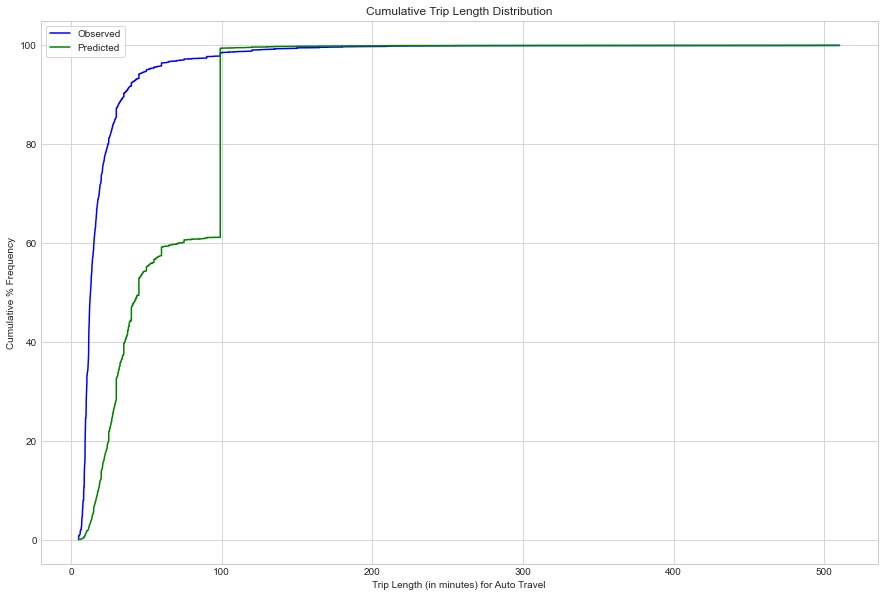

In [28]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(df['travel_time'], df['cum_obs'], '-b', label='Observed')
ax.plot(df['travel_time'], df['cum_pred'], '-g', label='Predicted')
ax.legend(loc='upper left', frameon=True);

plt.xlabel('Trip Length (in minutes) for Auto Travel')
plt.ylabel('Cumulative % Frequency')
plt.title('Cumulative Trip Length Distribution');